In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d, features_d*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d*2, features_d*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d*4, features_d*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(features_d*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, features_g*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(features_g*16),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g*16, features_g*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g*8, features_g*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g*4, features_g*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(),

            nn.ConvTranspose2d(features_g*2, channels_img, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


#MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/10 [00:00<?, ?it/s]


Loss D: 0.3992, Loss G: 1.9823


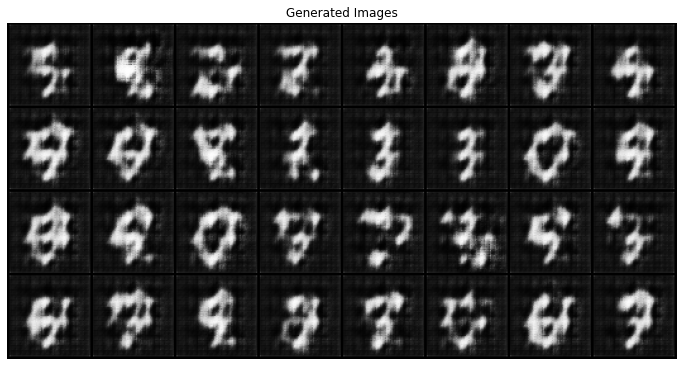

 10%|█         | 1/10 [07:11<1:04:47, 431.94s/it]


Loss D: 0.5065, Loss G: 0.8167


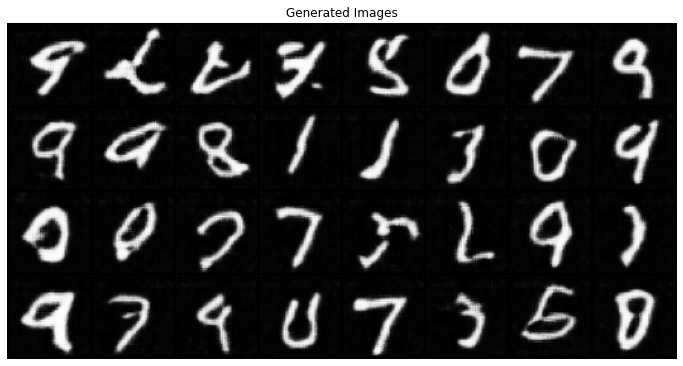

 20%|██        | 2/10 [14:22<57:29, 431.23s/it]  


Loss D: 0.3583, Loss G: 1.7952


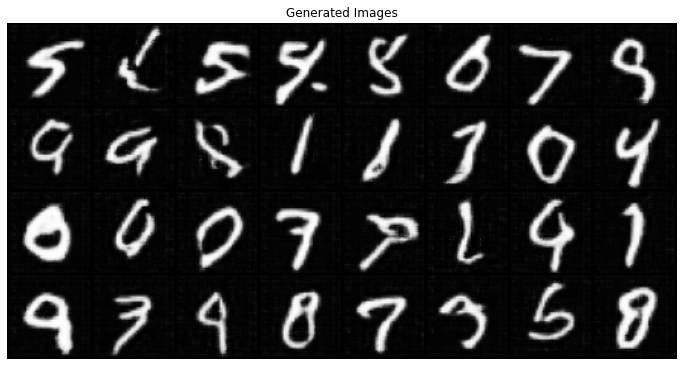

 30%|███       | 3/10 [21:32<50:15, 430.74s/it]


Loss D: 0.5112, Loss G: 2.8648


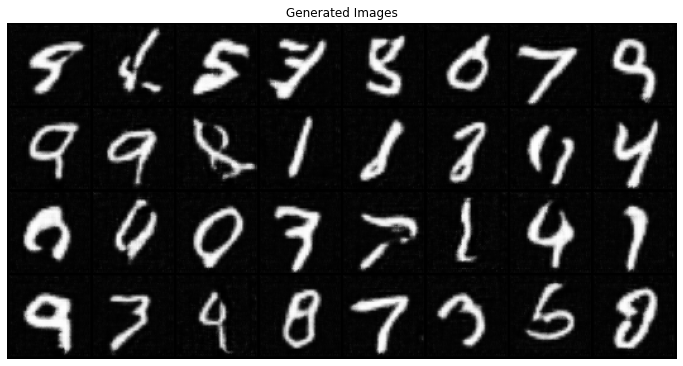

 40%|████      | 4/10 [28:43<43:03, 430.65s/it]


Loss D: 0.3310, Loss G: 1.1508


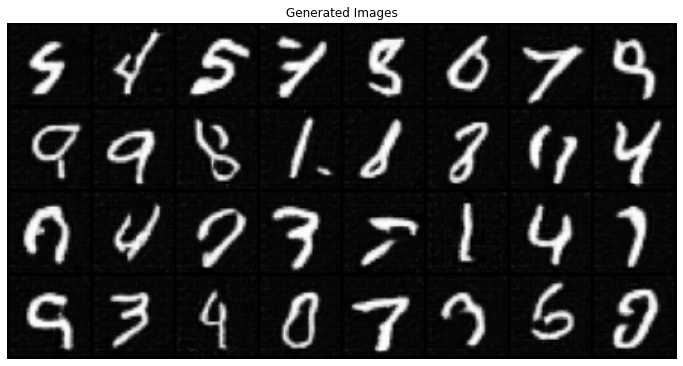

 50%|█████     | 5/10 [35:53<35:52, 430.48s/it]


Loss D: 0.3352, Loss G: 1.4499


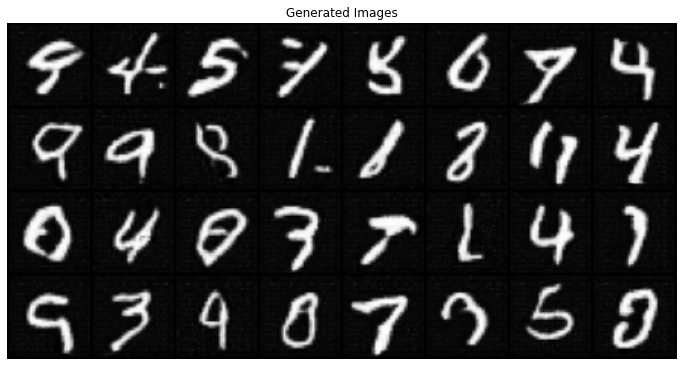

 60%|██████    | 6/10 [43:03<28:41, 430.30s/it]


Loss D: 0.3494, Loss G: 2.6348


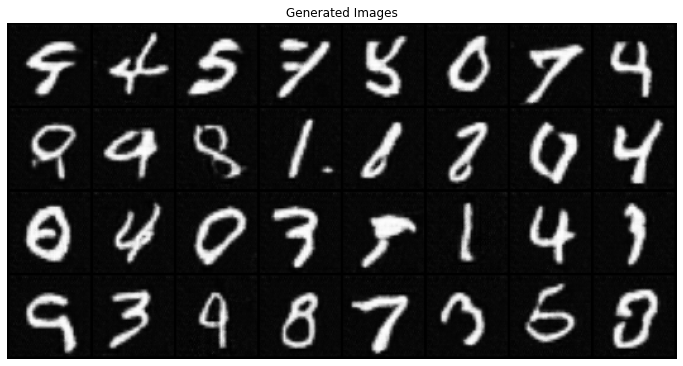

 70%|███████   | 7/10 [50:13<21:30, 430.15s/it]


Loss D: 0.4460, Loss G: 1.0898


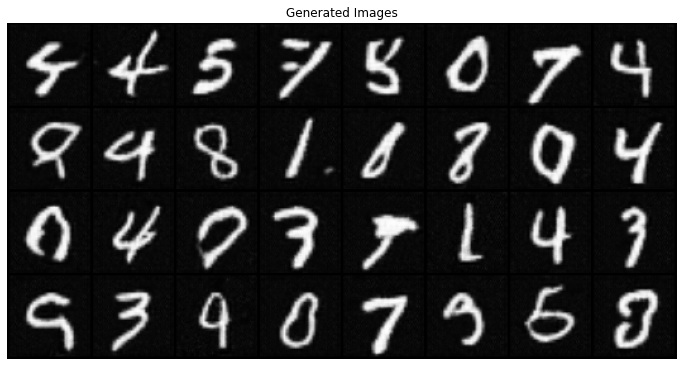

 80%|████████  | 8/10 [57:23<14:20, 430.04s/it]


Loss D: 0.4173, Loss G: 1.1300


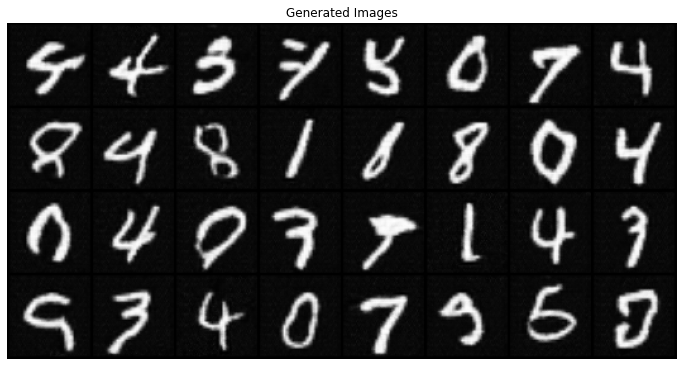

 90%|█████████ | 9/10 [1:04:34<07:10, 430.40s/it]


Loss D: 0.3570, Loss G: 2.4265


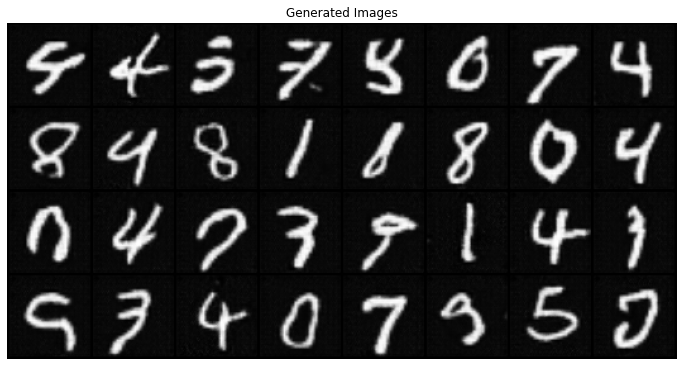

100%|██████████| 10/10 [1:11:47<00:00, 430.75s/it]


In [ ]:
#Hyperparameters
batch_size = 128
lr = 2e-4
image_size = 64
channels_img = 1
z_dim = 100
num_epochs = 10
features_d = 64
features_g = 64

#Preporations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
disc = Discriminator(channels_img, features_d).to(device)
gen = Generator(z_dim, channels_img, features_g).to(device)
initialize_weights(disc)
initialize_weights(gen)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))

transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(image_size),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize([0.5 for _ in range(channels_img)], [0.5 for _ in range(channels_img)])]
)
dataset = torchvision.datasets.MNIST(root='./', transform=transform, download=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss = nn.BCELoss() # -[y*log(x) + (1 - y)*log(1 - x)]

fixed_noise = torch.randn(32, z_dim, 1, 1).to(device)
D_losses = []
G_losses = []
img_list = []

gen.train()
disc.train()

#Training loop
for epoch in tqdm(range(num_epochs)):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
        fake = gen(noise)

        #Train Discriminator: max [log(D(real)) + log(1 - D(G(z)))]
        disc_real = disc(real).reshape(-1)
        lossD_real = loss(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        lossD_fake = loss(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_fake + lossD_real)/2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        #Train Generator: min log(1 - D(G(z))) <=> max log(D(G(z)))
        output = disc(fake).reshape(-1)
        lossG = loss(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    D_losses.append(lossD)
    G_losses.append(lossG)
    print(f"\nLoss D: {lossD:.4f}, Loss G: {lossG:.4f}")
    with torch.no_grad():
        fake = gen(fixed_noise)
    # fig, ax = plt.subplots(4, 8, figsize=(12, 8))
    # positions = ['top', 'left', 'right', 'bottom']
    # for i in range(len(fake)):
    #     ax[i//8, i%8].imshow(fake[i][0].cpu().numpy(), cmap='gray_r')
    #     for position in positions:
    #         ax[i//8, i%8].spines[position].set_visible(False)
    #     ax[i//8, i%8].get_xaxis().set_ticks([])
    #     ax[i//8, i%8].get_yaxis().set_ticks([])
    plt.figure(figsize=(12,12))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake.to(device)[:32], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray_r')
    plt.show()
    img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

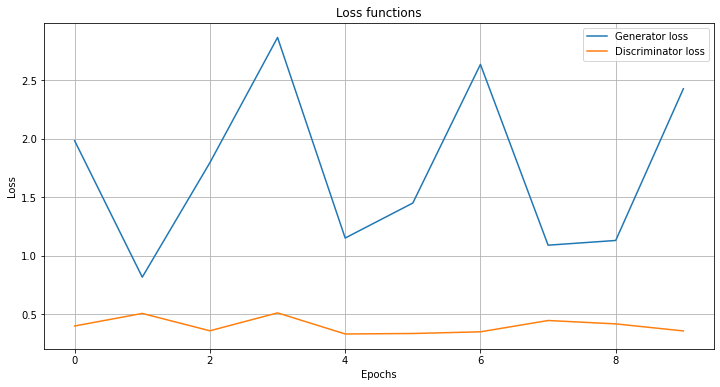

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(num_epochs), G_losses, label='Generator loss')
ax.plot(np.arange(num_epochs), D_losses, label='Discriminator loss')
ax.grid()
ax.legend()
ax.set(xlabel='Epochs', ylabel='Loss', title='Loss functions')
plt.show()

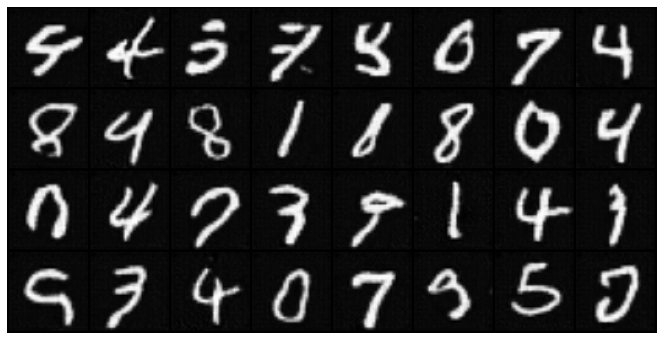

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())